<a href="https://colab.research.google.com/github/digital-science/dimensions-api-lab/blob/master/3-workshops/2019-06-Rotterdam-University/4-Rotterdam-university-simple-topic-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Dimensions API Lab In Google Colab"/></a>

# 4. Using the API to perform topic analysis 
This Notebook shows how it's possible to extract 'concepts' from publications and then use these terms in order to perform more advanced topic analyses tasks. 

> Warning: this notebook is still a work in progress!

In [30]:
import dimcli
from dimcli.shortcuts import dslquery, dslqueryall
import pandas as pd
from pandas.io.json import json_normalize
import plotly_express as px
from plotly.offline import init_notebook_mode # needed for exports 
init_notebook_mode(connected=True)
import time

In [21]:
GRIDID = "grid.6906.9" # Erasmus University Rotterdam

## Extracting most relevant concepts from publications about 'design' 

We are going to reuse the dataset from the previous exercise, which can be obtained simply by querying for the keyword 'design' in publication from Rotterdam University. 

It is important to remember that the list of concepts the API returns for each publication) is ordered by most-relevant first (eg `[contextual factors, homecare, nursing homes, ..]`). In other words, scores are implicit. So, in order to combine concepts from multiple publications, we will assign them a score automatically based on the position a concept has in the list (=the first concept gets the highest number). 

Let's take the first 20 concepts from each publication.

We also set up a `cleanup` function to automatically remove uninteresting concepts. 

In [25]:
data = dslqueryall(f"""search publications in title_abstract_only for "design" where research_orgs.id="{GRIDID}" return publications[concepts+year]""")

def cleanup_terms(concepts):
    blacklist = ['study', 'results', 'design', 'paper', 'effect', 'method', 'approach', 'findings', 'purpose', 'levels', 'years', 'review', 'example']
    o = []
    for x in concepts:
        if x not in blacklist and (not x.isupper()):
            o.append(x)
    return o
        
def concepts_extractor(dsl_results, cleanup=True, n=20):
    df = pd.DataFrame(columns=['concept', 'score', 'year'])
    for x in dsl_results:
        if 'concepts' in x:
            concepts = x['concepts'][:n]
            if cleanup:
                concepts = cleanup_terms(concepts)
            if concepts:
                llen = len(concepts)
                scores = list(range(1, llen+1))[::-1] # highest score first
                years = [x["year"]] * llen
                z = list(zip(concepts, scores, years))
                d = [{'concept': a, 'score': b, 'year': c} for a,b,c in z]
                df = df.append(d, sort=True)
    return df
          
df = concepts_extractor(data.publications, True)

1000 / 1874
1874 / 1874


## Top concepts: a first look

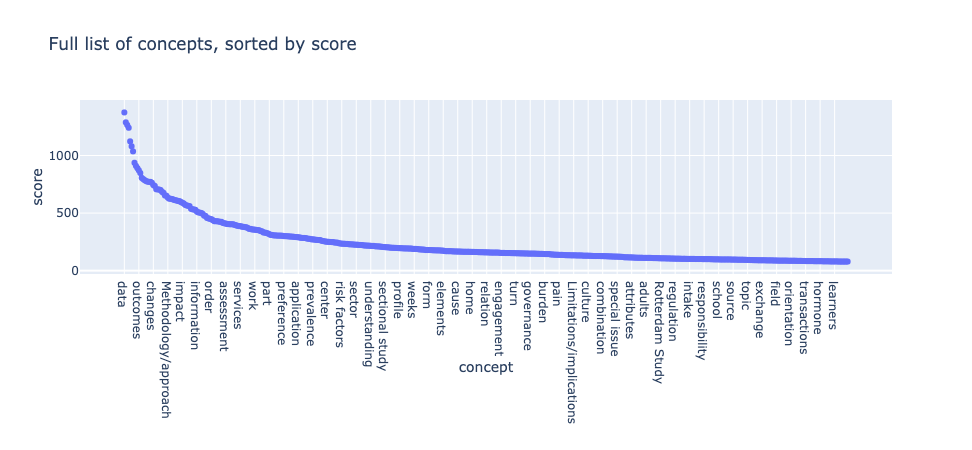

In [26]:
df_by_concept = df.groupby('concept', as_index=False).sum()
df_by_concept = df_by_concept.sort_values(by="score",  ascending=False)
df_by_concept = df_by_concept.reset_index(drop=True)
px.scatter(df_by_concept.head(500), x="concept", y="score", title="Full list of concepts, sorted by score")

## Segmenting concepts by year

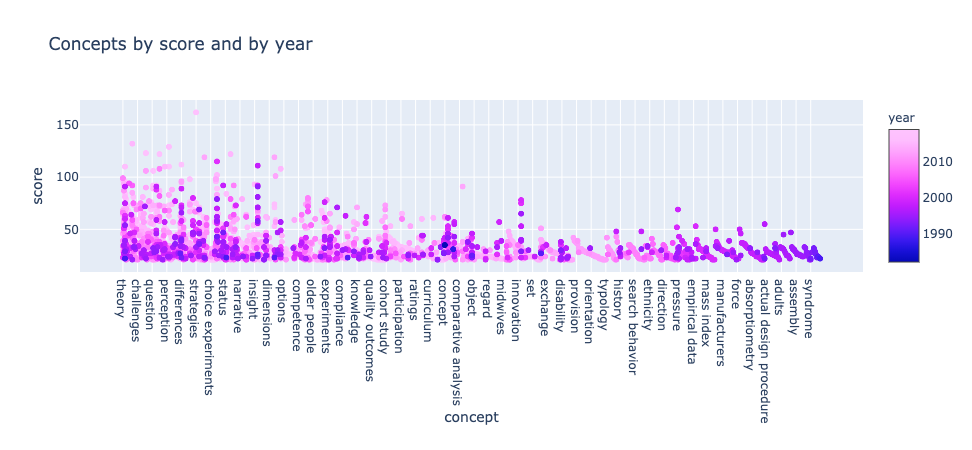

In [27]:
df_by_year = df.groupby(['year', 'concept'], as_index=False).sum()
df_by_year = df_by_year.sort_values(by=["year", "score"],  ascending=False)
df_by_year = df_by_year.reset_index(drop=True)
px.scatter(df_by_year.query("score>20"), x="concept", y="score", color="year", title="Concepts by score and by year")

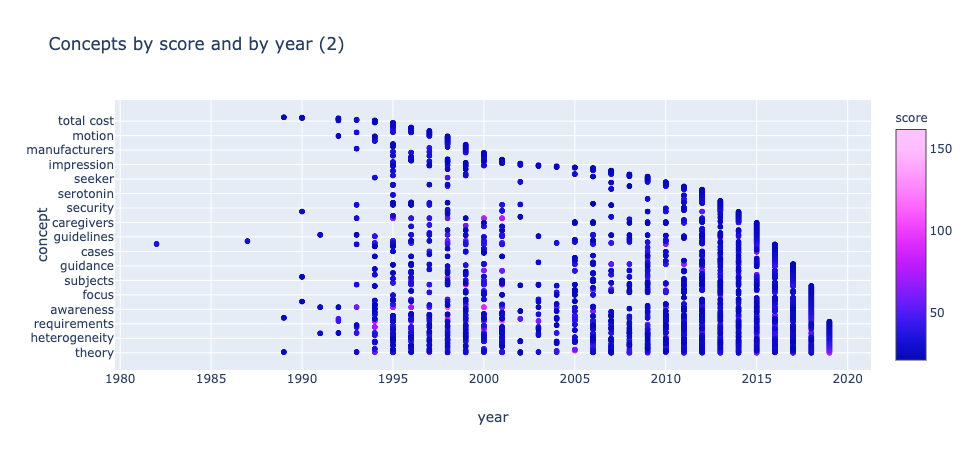

In [28]:
px.scatter(df_by_year.query("score>20"), x="year", y="concept", color="score", height=800, title="Concepts by score and by year (2)")

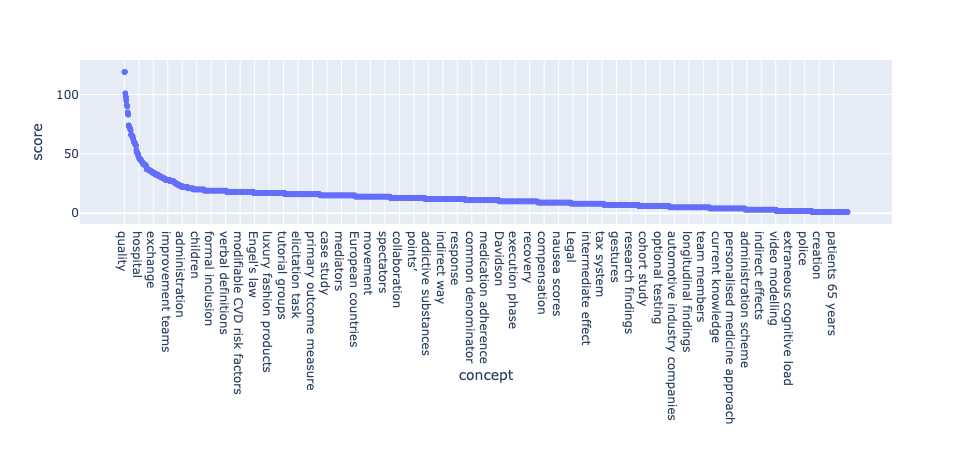

In [29]:
px.scatter(df_by_year.query("year==2013"), x="concept", y="score")

### Next steps
* apply term frequency–inverse document frequency algorithms to identify more significant concepts 
* try segmentation by broad research area
* try segmentation by year 

---
# Want to learn more?

Check out the [Dimensions API Lab](https://digital-science.github.io/dimensions-api-lab/) website, which contains many tutorials and reusable Jupyter notebooks for scholarly data analytics. 